In [18]:
!pip install --upgrade git+https://github.com/matthias-wright/flaxmodels.git
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/matthias-wright/flaxmodels.git to /tmp/pip-req-build-8qdv4h2c
  Running command git clone -q https://github.com/matthias-wright/flaxmodels.git /tmp/pip-req-build-8qdv4h2c
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
from PIL import Image
import jax
import jax.numpy as jnp
import flaxmodels as fm
import matplotlib.pyplot as plt
from jax import jit, random, grad
import numpy as np
import optax
from functools import partial
from tqdm import trange
from jax.example_libraries import optimizers
from google.colab import drive
drive.mount('/content/drive')

mult = 150

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [21]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 19 00:11:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |  14184MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
!wget https://www.opi.com/sites/default/files/styles/product_photos/public/you-had-me-at-confetti-brush-swatch.jpg
!wget https://d1e00ek4ebabms.cloudfront.net/production/a4c161aa-5365-458d-b5b0-e03c98eb1e78.jpg

--2022-12-19 00:11:18--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg.10’

picasso.jpg.10      100%[===================>] 111.89K  --.-KB/s    in 0.002s  

2022-12-19 00:11:18 (43.7 MB/s) - ‘picasso.jpg.10’ saved [114573/114573]

--2022-12-19 00:11:18--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg.10’

dancing.jpg.10      100%[===================>]  39.54K  --.-KB/s    in 0.004s  

2022-12-19 00:11:18 (1

# Load your image

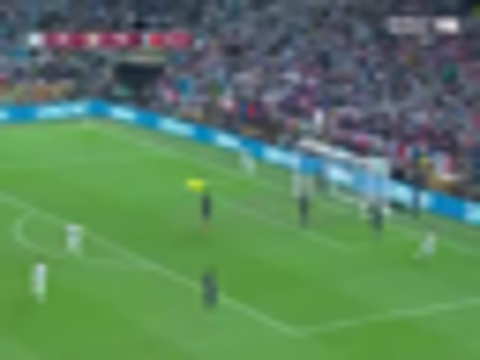

(64, 64)


In [23]:
# Load image
#img_con = Image.open('dancing.jpg').resize((256,256))
import cv2

ss = 64

cap = cv2.VideoCapture("argentina-vs.france-highlights-2022-fifa-worl.mp4") # says we capture an image from a webcam

img_con = None
img_list = []
img_con2 = None
i = 0

while(cap.isOpened()): 
  ret, im = cap.read()
  if ret:
    frame = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    img = Image.fromarray(frame).resize((ss,ss))

    if img_con == None:
      img_con = img
    elif img_con2 == None:
      img_con2 = img
    #if(len(img_list) < mult):
    if(i > 77*30):
      #display(img.resize((480, 360)))
      img_list.append(img)
    if i > 87*30-15:
      #display(img.resize((480, 360)))
      break
    #print(i)
    i += 1
  else:
    break

cap.release()

display(img_list[-1].resize((480, 360)))
print(img_con.size)
#img_con = [img_con, img_con2]

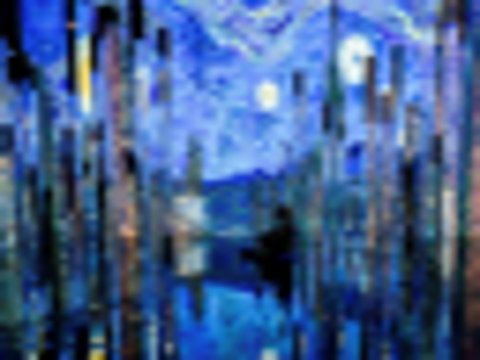

In [24]:
img_sty = Image.open('a4c161aa-5365-458d-b5b0-e03c98eb1e78.jpg').resize((ss,ss))
display(img_sty.resize((480, 360)))

# Normalize it

In [25]:
cnn_normalization_mean = jnp.array([0.485, 0.456, 0.406])
cnn_normalization_std = jnp.array([0.229, 0.224, 0.225])

In [26]:
# Image should be in range [0, 1]
image_content = []

print(len(img_list))

for i in img_list:
  image_content.append(jnp.array(i, dtype=jnp.float32) / 255.0)
#image_content = jnp.array(img_con, dtype=jnp.float32) / 255.0
#image_content2 = jnp.array(img_con2, dtype=jnp.float32) / 255.0

# Add batch dimension
# img_content = jnp.expand_dims(image_content, axis=0)
# img_content2 = jnp.expand_dims(image_content2, axis=0)
img_content = jnp.stack(image_content, axis=0)
print(img_content.shape)

286
(286, 64, 64, 3)


In [27]:
image_style = jnp.array(img_sty, dtype=jnp.float32) / 255

#img_style = jnp.expand_dims(image_style, axis=0)
img_style = jnp.stack([image_style]*2)
print(img_style.shape)

(2, 64, 64, 3)


# Loss function

In [28]:
class StyleTransfer:
  def __init__(self, input_content, input_style, content_layers, style_layers):
    # Original style and content input
    self.origin_content = input_content
    self.origin_style = input_style

    # Initialize Pretrained model
    self.vgg19 = fm.VGG16(output='activations', pretrained='imagenet', include_head=False)
    self.init_rngs = {'params': jax.random.PRNGKey(0)}#, 'dropout': jax.random.PRNGKey(1)}
    self.vggparams = self.vgg19.init(self.init_rngs, img_content)
    self.fn_out = jit(self.vgg19.apply)

    # Get VGG activation of original style and content input
    self.activation_style_origin = self.fn_out(self.vggparams, self.origin_style, train=False)
    self.activation_content_origin = self.fn_out(self.vggparams, self.origin_content, train=False)

    # Initialize style layer and content layer
    self.layer_style = style_layers
    self.layer_content = content_layers

    #Initialize style and content weights
    self.style_weight=1000000000
    self.content_weight=1
    self.temporal_weight = 1000

    # Initialize Optimizer
    self.lr = 1e-3
    self.optimizer = optax.adam(learning_rate = self.lr)

    # Initialize generated image
    self.generate_img = self.origin_content.copy()
    self.opt_state = self.optimizer.init(self.generate_img)

  def reinit(self, input_content):
    # Original style and content input
    self.origin_content = input_content

    # Initialize Pretrained model
    self.vgg19 = fm.VGG19(output='activations', pretrained='imagenet', include_head=False)
    self.init_rngs = {'params': jax.random.PRNGKey(0)}#, 'dropout': jax.random.PRNGKey(1)}
    self.vggparams = self.vgg19.init(self.init_rngs, img_content)
    self.fn_out = jit(self.vgg19.apply)

    # Get VGG activation of original style and content input
    self.activation_style_origin = self.fn_out(self.vggparams, self.origin_style, train=False)
    self.activation_content_origin = self.fn_out(self.vggparams, self.origin_content, train=False)

    #Initialize style and content weights
    self.style_weight=1000000000
    self.content_weight=1
    self.temporal_weight = 1000

    # Initialize Optimizer
    self.lr = 1e-3
    self.optimizer = optax.adam(learning_rate = self.lr)

    # Initialize generated image
    self.generate_img = self.origin_content.copy()
    self.opt_state = self.optimizer.init(self.generate_img)

  @partial(jit, static_argnums=(0,))
  def gram_matrix(self, input):
    input = jnp.transpose(input, axes=(0, 3, 1, 2))
    a, b, c, d = input.shape #a=1, batchsize, b=3 number of feature maps, (c,d) size of feature map
    features = input.reshape(a * b, c * d)
    G = features @ features.T
    return G / (a * b * c * d)

  @partial(jit, static_argnums=(0,))
  def content_loss(self, input_content, img_generated):
    return jnp.mean((input_content.flatten()-img_generated.flatten()) ** 2)

  @partial(jit, static_argnums=(0,))
  def temporal_loss(self, input_content, img_generated):
    return jnp.mean((img_generated[0].flatten()-img_generated[1].flatten()) ** 2)
  
  @partial(jit, static_argnums=(0,))
  def style_loss(self, input_style, img_generated):
    return jnp.mean((input_style - img_generated) ** 2)

  @partial(jit, static_argnums=(0,))
  def loss(self, img_generated):
    out_generated = self.fn_out(self.vggparams, img_generated, train=False)
    
    style_score = 0
    content_score = 0
    temporal_score = 0

    for cont_layer in self.layer_content:
      content_score += self.content_loss(self.activation_content_origin[cont_layer], out_generated[cont_layer])
      temporal_score += self.temporal_loss(self.activation_content_origin[cont_layer], out_generated[cont_layer])
    
    for sty_layer in self.layer_style:
      gram_sty = self.gram_matrix(self.activation_style_origin[sty_layer])
      gram_gen = self.gram_matrix(out_generated[sty_layer])
      style_score += self.style_loss(gram_sty, gram_gen)

    print("*****")
    print(temporal_score)
    print(content_score)
    print(style_score)
    
    loss = self.style_weight * style_score + self.content_weight * content_score + self.temporal_weight * temporal_score
    return loss
  
  @partial(jit, static_argnums=(0,))
  def step(self, optimizer_state, img_generated):
    #print("in step")
    grads = grad(self.loss)(img_generated)
    #print("calced grads")
    updates, opt_state = self.optimizer.update(grads, optimizer_state, img_generated)
    #print("did updates")
    return optax.apply_updates(img_generated, updates), opt_state

  def train(self, imgs, iter = 500):
    retArray = []

    for i in trange(imgs.shape[0]-1):
      self.reinit(imgs[i:i+2,:,:,:])
      #print(self.generate_img.shape)
      for iter in range(500):
        #print("entering step")
        #print(self.generate_img.shape)
        self.generate_img, self.opt_state = self.step(self.opt_state, self.generate_img)
        #print("exiting step")
        self.generate_img = jnp.clip(self.generate_img, 0, 1)

      retArray.append(jnp.clip(self.generate_img, 0, 1))

      # for i in trange(imgs.shape[0]-1):
      #   self.reinit(imgs[i:i+2,:,:,:])
      #   #print(self.generate_img.shape)
      #   for iter in range(500):
      #     #print("entering step")
      #     #print(self.generate_img.shape)
      #     self.generate_img, self.opt_state = self.step(self.opt_state, self.generate_img)
      #     #print("exiting step")
      #     self.generate_img = jnp.clip(self.generate_img, 0, 1)

      #   retArray[i] += jnp.clip(self.generate_img, 0, 1)
      #   retArray[i] /= 2
      #break
      #todo change to vgg apply and remove reinit maybe? unsure

      #plt.imshow(self.generate_img[0])
    #   break
    
    # retArray = []

    # for i in trange(imgs.shape[0]-1):
    #   #self.reinit(imgs[i:i+2,:,:,:])
    #   #print(self.generate_img.shape)
    #   self.reinit(imgs[i:i+2,:,:,:])
    #   #print("entering step")
    #   #print(self.generate_img.shape)Nti
    #   out_generated = self.step(self.opt_state, self.generate_img)
    #   #out_generated = self.fn_out(self.vggparams, imgs[i:i+2], train=False)
    #   #print(out_generated)
    #   #print("exiting step")
    #   #print(out_generated)
    #   retArray.append(jnp.clip(out_generated[0], 0, 1))
    #   retArray.append(out_generated)
    # plt.imshow(retArray[0][0])
    return retArray




# Train

In [29]:
content_layers_default = ['conv2_2']
style_layers_default = ['conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1']

In [30]:
sty_trans = StyleTransfer(img_content[:2], img_style, content_layers_default, style_layers_default)
output = sty_trans.train(img_content)

  0%|          | 0/285 [00:00<?, ?it/s]

*****
Traced<ShapedArray(float32[])>with<JVPTrace(level=2/2)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/2)>
  tangent = Traced<ShapedArray(float32[])>with<JaxprTrace(level=1/2)> with
    pval = (ShapedArray(float32[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x7f5940034770>, in_tracers=(Traced<ShapedArray(float32[]):JaxprTrace(level=1/2)>,), out_tracer_refs=[<weakref at 0x7f59207de590; to 'JaxprTracer' at 0x7f59207de5e0>], out_avals=[ShapedArray(float32[])], primitive=xla_call, params={'device': None, 'backend': None, 'name': 'fn', 'donated_invars': (False,), 'inline': True, 'keep_unused': False, 'call_jaxpr': { lambda ; a:f32[]. let  in (a,) }}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x7f5953f619f0>, name_stack=NameStack(stack=())))
Traced<ShapedArray(float32[])>with<JVPTrace(level=2/2)> with
  primal = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/2)>
  tangent = Tr

100%|██████████| 285/285 [08:21<00:00,  1.76s/it]


(2, 64, 64, 3)


100%|██████████| 285/285 [00:01<00:00, 255.80it/s]


<class 'numpy.ndarray'>


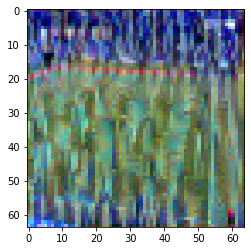

In [31]:
#plt.imshow(output[0])
print(output[0].shape)
videodims = (output[0].shape[1], output[0].shape[2])
fourcc = cv2.VideoWriter_fourcc("F","M","P","4")    
video = cv2.VideoWriter("dimaria.mp4",fourcc, 30,videodims)
img = Image.new('RGB', videodims, color = 'darkred')

ii = None
iii = None

#draw stuff that goes on every frame here
for i in trange(0,len(output)):
    imtemp = output[i][0,:,:,:].copy()
    if i > 0:
      imtemp += output[i-1][1,:,:,:].copy()
      imtemp /= 2

    if i == 10:
      ii = imtemp.copy()
    if i == 11:
      iii = imtemp.copy()
    # draw frame specific stuff here.
    video.write(cv2.cvtColor(np.uint8(np.array(imtemp)*255), cv2.COLOR_RGB2BGR))
video.release()

x = np.abs(np.asarray(ii-iii))*25*100
print(type(x))

#print(x)

cv2.imwrite('dimaria.jpg', x)

plt.imshow(output[1][0])